# Approche de la prédiction des rôles rhétoriques (RR) dans les documents juridiques indiens en langue anglaise par l'utilisation de Transformers

In [1]:
# local
#import os
#ROOT = os.path.abspath('')

In [2]:
# Connecter Colab à Google Drive
from google.colab import drive
drive.mount('/content/drive')
ROOT = '/content/drive/MyDrive/Colab Notebooks/Tache SemEval/Projet_SemEval2023_ATAL/'

Mounted at /content/drive


In [3]:
%pip install transformers accelerate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00


In [4]:
import torch, os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, RobertaTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding


import spacy
import re
import json

import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.utils import resample, shuffle, compute_class_weight
from transformers import EvalPrediction

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


Chargement des Data:

In [6]:
train_df = pd.read_csv(os.path.join(ROOT, 'BUILD/train.csv'))
valid_df = pd.read_csv(os.path.join(ROOT, 'BUILD/dev.csv'))
test_df = pd.read_csv(os.path.join(ROOT, 'BUILD/test.csv'))
extended_train_df = pd.read_csv(os.path.join(ROOT, 'BUILD/extended_train_dataset.csv'))

<ipython-input-6-95120531d619>:4: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  extended_train_df = pd.read_csv(os.path.join(ROOT, 'BUILD/extended_train_dataset.csv'))


In [ ]:
#extended_train_df.shape


(200020, 9)

In [ ]:
#train_df.shape

(26087, 9)

#### Dataset augmenté

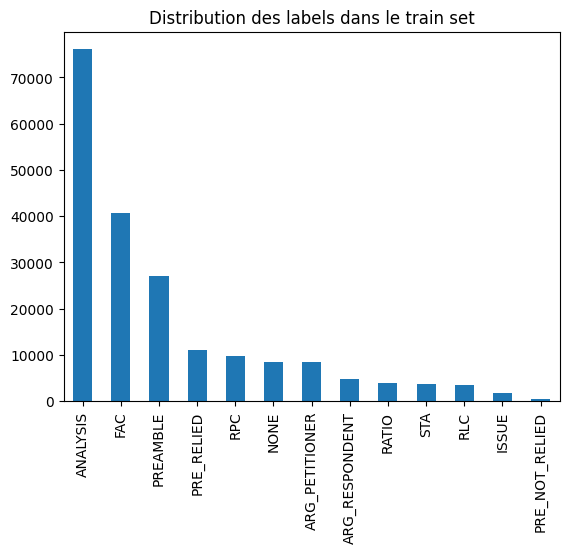

In [10]:
extended_train_df["labels"].value_counts().plot(kind='bar')
plt.title('Distribution des labels dans le train set')
plt.show()


In [11]:
#compter la distribution des labels dans le test set
extended_train_df["labels"].value_counts()

ANALYSIS          76077
FAC               40626
PREAMBLE          26977
PRE_RELIED        11184
RPC                9862
NONE               8453
ARG_PETITIONER     8385
ARG_RESPONDENT     4849
RATIO              3919
STA                3734
RLC                3589
ISSUE              1811
PRE_NOT_RELIED      554
Name: labels, dtype: int64

Mapage des labels:

In [7]:
rr_labels = [
    'PREAMBLE',
    'FAC',
    'RLC',
    'ISSUE',
    'ARG_PETITIONER',
    'ARG_RESPONDENT',
    'ANALYSIS',
    'STA',
    'PRE_RELIED',
    'PRE_NOT_RELIED',
    'RATIO',
    'RPC',
    'NONE'
]
MAP_LABEL = {k: i for i, k in enumerate(rr_labels)}
print(MAP_LABEL)

{'PREAMBLE': 0, 'FAC': 1, 'RLC': 2, 'ISSUE': 3, 'ARG_PETITIONER': 4, 'ARG_RESPONDENT': 5, 'ANALYSIS': 6, 'STA': 7, 'PRE_RELIED': 8, 'PRE_NOT_RELIED': 9, 'RATIO': 10, 'RPC': 11, 'NONE': 12}


In [8]:
train_df["labels_class"] = train_df['labels'].apply(lambda x: MAP_LABEL[x])
valid_df["labels_class"] = valid_df['labels'].apply(lambda x: MAP_LABEL[x])


Distribution des classes:

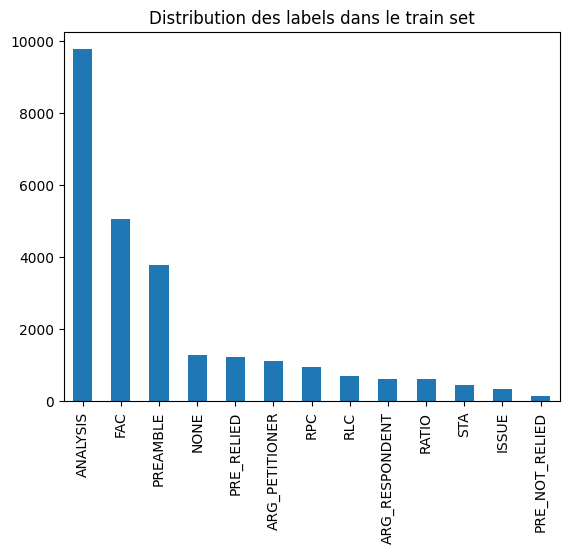

In [9]:
train_df["labels"].value_counts().plot(kind='bar')
plt.title('Distribution des labels dans le train set')
plt.show()

In [ ]:
#compter la distribution des labels dans le train set
train_df["labels"].value_counts()

ANALYSIS          9765
FAC               5070
PREAMBLE          3778
NONE              1286
PRE_RELIED        1221
ARG_PETITIONER    1120
RPC                954
RLC                711
ARG_RESPONDENT     620
RATIO              619
STA                443
ISSUE              344
PRE_NOT_RELIED     156
Name: labels, dtype: int64

### Création d'un dataset avec du random over-sampling de la classe minoritaire:

In [12]:
from imblearn.over_sampling import RandomOverSampler

# Initialiser l'échantillonneur aléatoire
ros = RandomOverSampler(random_state=42)

# Données sous forme de X (features) et y (labels) pour RandomOverSampler.
# Dans ce cas, X pourrait être juste un ensemble de numéros de ligne, car nous n'utilisons pas vraiment les données pour le suréchantillonnage.
X = train_df.index.values.reshape(-1, 1)
y = train_df["labels"].values

X_resampled, y_resampled = ros.fit_resample(X, y)

# Créer un nouveau DataFrame à partir des indices suréchantillonnés
Random_Over_Sample_train_df = train_df.loc[X_resampled.flatten()]

# Vérifier le nouvel équilibre des classes
print(Random_Over_Sample_train_df["labels"].value_counts())


PREAMBLE          9765
NONE              9765
FAC               9765
ARG_RESPONDENT    9765
RLC               9765
ARG_PETITIONER    9765
ANALYSIS          9765
PRE_RELIED        9765
RATIO             9765
RPC               9765
ISSUE             9765
STA               9765
PRE_NOT_RELIED    9765
Name: labels, dtype: int64


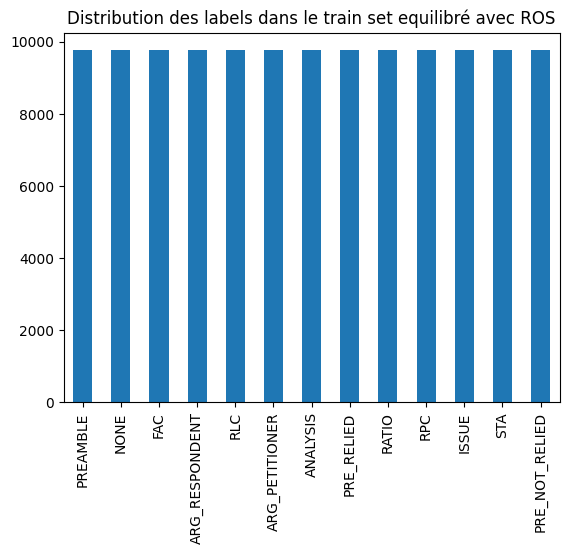

In [13]:
Random_Over_Sample_train_df["labels"].value_counts().plot(kind='bar')
plt.title('Distribution des labels dans le train set equilibré avec ROS')
plt.show()

#### Estimation de la longueur des textes

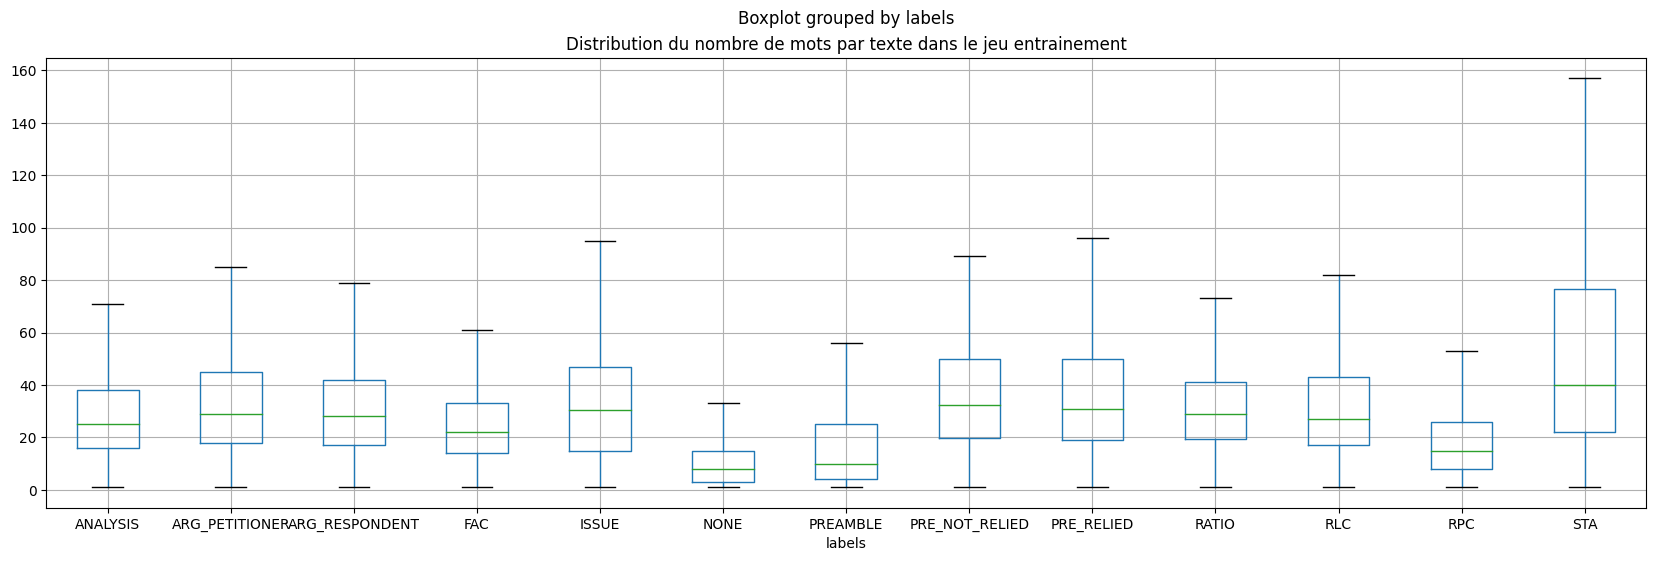

In [ ]:
#estimation de la longueur des textes dans le train set de base
train_df['mots_par_texte'] = train_df['text'].apply(lambda x: len(x.split()))
train_df.boxplot(column='mots_par_texte', by='labels', figsize=(20, 6), showfliers=False)
plt.title('Distribution du nombre de mots par texte dans le jeu entrainement')
plt.show()

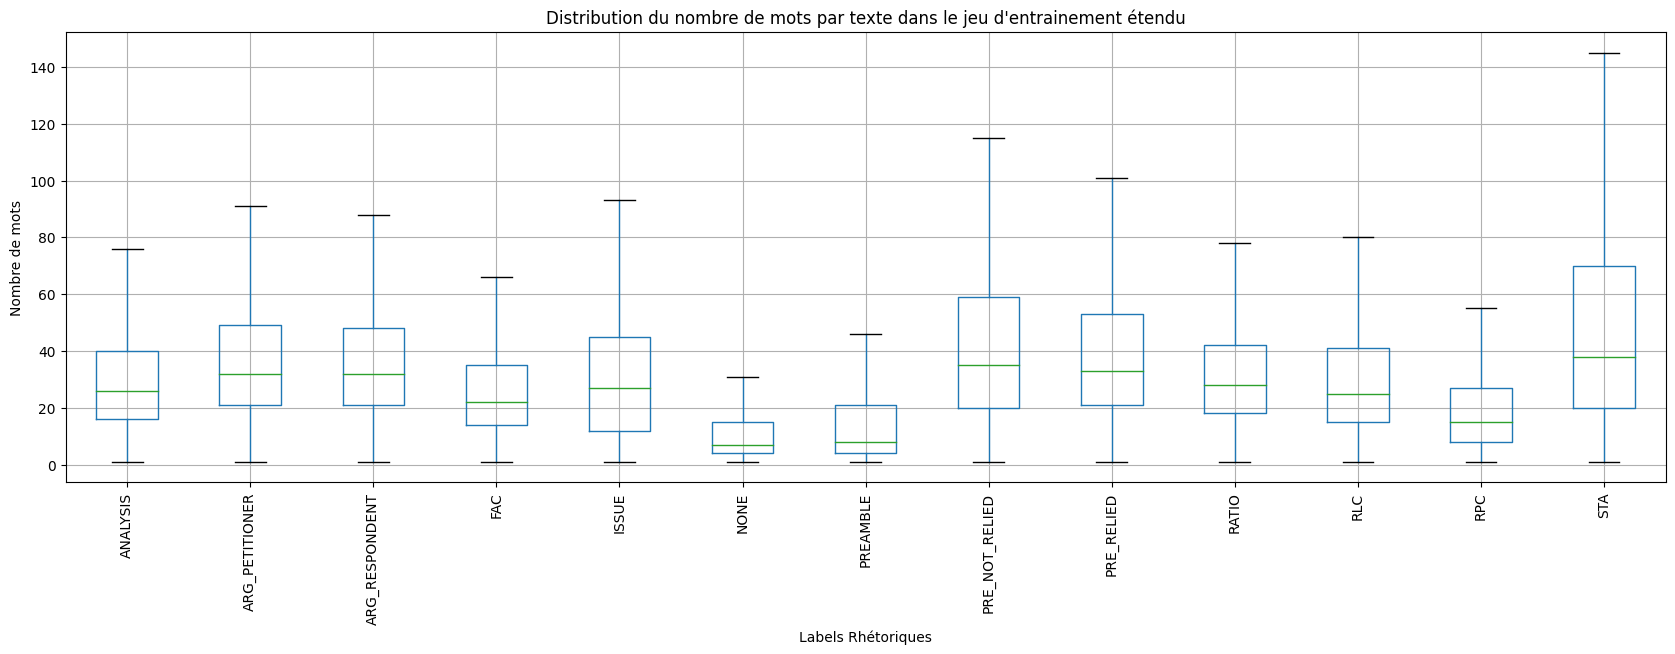

In [ ]:
# Estimation de la longueur des textes dans extended_train_df
extended_train_df['mots_par_texte'] = extended_train_df['text'].apply(lambda x: len(x.split()))

extended_train_df.boxplot(column='mots_par_texte', by='labels', figsize=(20, 6), showfliers=False)
plt.title('Distribution du nombre de mots par texte dans le jeu d\'entrainement étendu')
plt.suptitle('')
plt.xlabel('Labels Rhétoriques')
plt.ylabel('Nombre de mots')
plt.xticks(rotation=90)  # Rotation des étiquettes de l'axe des x pour +de lisibilité
plt.show()


## Balanced Train Dataset sur le dataset étendu

In [ ]:
# Creer un nouveau DataFrame pour le dataset équilibré.
balanced_train_df = pd.DataFrame()

# Utiliser la classe minoritaire (hors PRE_NOT_RELIED) comme référence pour le rééchantillonnage.
target_count = extended_train_df['labels'].value_counts().drop('PRE_NOT_RELIED').min()

for label in extended_train_df['labels'].unique():
    if label == 'PRE_NOT_RELIED':
        label_df = extended_train_df[extended_train_df['labels'] == label]
    else:
        # Rééchantillonnage de chaque classe pour atteindre 'target_count'.
        label_df = resample(
            extended_train_df[extended_train_df['labels'] == label],
            replace=True,  # Avec remplacement.
            n_samples=target_count,  # Pour atteindre l'équilibre.
            random_state=42  # Pour la reproductibilité.
        )
    balanced_train_df = pd.concat([balanced_train_df, label_df])

# Mélanger le dataset équilibré.
balanced_train_df = shuffle(balanced_train_df, random_state=42)

# Enregistrer le dataset équilibré.
balanced_train_df.to_csv(os.path.join(ROOT, 'BUILD/balanced_train_dataset.csv'), index=False)


In [ ]:
print(balanced_train_df["labels"].value_counts())

ARG_RESPONDENT    1811
STA               1811
ARG_PETITIONER    1811
PRE_RELIED        1811
RLC               1811
NONE              1811
FAC               1811
RPC               1811
PREAMBLE          1811
RATIO             1811
ISSUE             1811
ANALYSIS          1811
PRE_NOT_RELIED     554
Name: labels, dtype: int64


## Transformers

In [ ]:
# Charger le modèle

def load_model(path, device, **kwargs):
    model = AutoModelForSequenceClassification.from_pretrained(path, **kwargs)
    model = model.to(device)
    return model

def load_tokenizer(path):
    tokenizer = AutoTokenizer.from_pretrained(path)
    return tokenizer

In [ ]:
# Charger le modèle anglais de spaCy si besoin de preprocessing des textes
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Pretraitement des donnees
def _preprocess(text: str) -> str:
    # To clean the text, replace tokens, ...

    # Supprimer les caractères spéciaux et les espaces superflus
    text = re.sub(r'\s+', ' ', text.replace('\n', ' '))

    # Convertir le texte en minuscules
    text = text.lower()

    # Traitement avec spaCy
    doc = nlp(text)

    # Supprimer les stop words et faire de la lemmatisation
    cleaned_text = ' '.join(token.lemma_ for token in doc if not token.is_stop)

    # Retourner le texte nettoyé
    return cleaned_text

In [ ]:
class BUILDDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, device, include_labels=True):
        self.ids = df.index.tolist()
        self.encodings = tokenizer(
            df['text'].tolist(),
            truncation=True,
            padding=False,
            max_length=512
        )
        self.include_labels = include_labels
        if include_labels and 'labels_class' in df:
            self.labels = df['labels_class'].tolist()
        else:
            self.labels = [0] * len(df)  # Utilisez une étiquette par défaut, par ex. 0

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.include_labels:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])


Evaluation:

In [ ]:
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Perte equillibre selon la distribution

Non utilisé, à l'origine pour donner plus de poid aux classes minoritaires mais ne fonctionne pas.

In [ ]:
# Calculer les poids pour chaque classe en fonction de leur fréquence inverse
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(extended_train_df['labels_class']),
    y=extended_train_df['labels_class']
)

# Convertir en dictionnaire pour une utilisation avec PyTorch
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


In [ ]:
class_weights_dict

{0: 0.5703433979372742,
 1: 0.3787267721693951,
 2: 4.287030884969029,
 3: 8.495943592575287,
 4: 1.834961699004633,
 5: 3.1730570934530515,
 6: 0.2022444871137643,
 7: 4.120555395327758,
 8: 1.3757290634973038,
 9: 27.77284087753402,
 10: 3.9260407874850336,
 11: 1.5601453910113412,
 12: 1.8202003840238787}

Tokenization:

In [ ]:
tokenizer = load_tokenizer("nlpaueb/legal-bert-small-uncased")
model = load_model("nlpaueb/legal-bert-small-uncased", device, num_labels=len(rr_labels))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/989 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/141M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(rr_labels))
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(rr_labels))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Padding Dynamique

In [ ]:
# Créer une instance de DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

#### Création des datasets

Il faut décomenter et utiliser le train set que l'on souhaite.

In [ ]:
#train_dataset = BUILDDataset(train_df, tokenizer, device)

In [ ]:
valid_dataset = BUILDDataset(valid_df, tokenizer, device)

In [ ]:
#ROS_train_dataset = BUILDDataset(Random_Over_Sample_train_df, tokenizer, device)

In [ ]:
extended_train_dataset = BUILDDataset(extended_train_df, tokenizer, device)

In [ ]:
#extended_train_dataset_balanced = BUILDDataset(balanced_train_df, tokenizer, device)

Configuration du modèle:

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,             # total number of training epochs
    #max_steps=500,                    # trains for 10 batches
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy='epoch', # evaluer à chaque epoch
    save_strategy='epoch', # sauvegarder à chaque epoch
    #report_to="tensorboard",  # Ajoutez cette ligne pour utiliser TensorBoard
    learning_rate=1e-4, # taux d'apprentissage 5e-4, 1e-4(legal bert training)
)

trainer = Trainer(
    model=model.to(device),                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=extended_train_dataset,         # training dataset
    eval_dataset=valid_dataset,             # evaluation dataset
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


AttributeError: 'SequenceClassifierOutput' object has no attribute 'shape'

Inférence et évaluation:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Faire les prédictions sur les données de validation
predictions = trainer.predict(valid_dataset)

In [ ]:
# Obtention des étiquettes prédites et les vraies étiquettes
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = valid_dataset.labels


In [ ]:
# Calcul des scores de précision, de rappel et de f-mesure
report = classification_report(true_labels, predicted_labels, target_names=rr_labels, output_dict=True)

In [ ]:
# Afficher le rapport dans un DataFrame
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
PREAMBLE,0.860870,0.763496,0.809264,389.000000
FAC,0.626357,0.599407,0.612585,674.000000
RLC,0.170103,0.804878,0.280851,41.000000
ISSUE,0.431373,0.956522,0.594595,23.000000
ARG_PETITIONER,0.427027,0.405128,0.415789,195.000000
ARG_RESPONDENT,0.235294,0.307692,0.266667,78.000000
ANALYSIS,0.634921,0.430108,0.512821,930.000000
STA,0.365854,0.789474,0.500000,38.000000
PRE_RELIED,0.536424,0.385714,0.448753,210.000000
PRE_NOT_RELIED,0.000000,0.000000,0.000000,2.000000


In [ ]:
# Sauvegarder le modèle
model_save_path = os.path.join(ROOT, 'Model/Distilbert')
model.save_pretrained(model_save_path)

# Sauvegarder le tokenizer
tokenizer_save_path = os.path.join(ROOT, 'Model/Distilbert_Tokenizer')
tokenizer.save_pretrained(tokenizer_save_path)


('/content/drive/MyDrive/Colab Notebooks/Tache SemEval/Projet_SemEval2023_ATAL/Model/Tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Tache SemEval/Projet_SemEval2023_ATAL/Model/Tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Tache SemEval/Projet_SemEval2023_ATAL/Model/Tokenizer/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/Tache SemEval/Projet_SemEval2023_ATAL/Model/Tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/Tache SemEval/Projet_SemEval2023_ATAL/Model/Tokenizer/tokenizer.json')

Matrice de confusion:

In [ ]:
# Calculer la matrice de confusion
confusion = confusion_matrix(true_labels, predicted_labels)

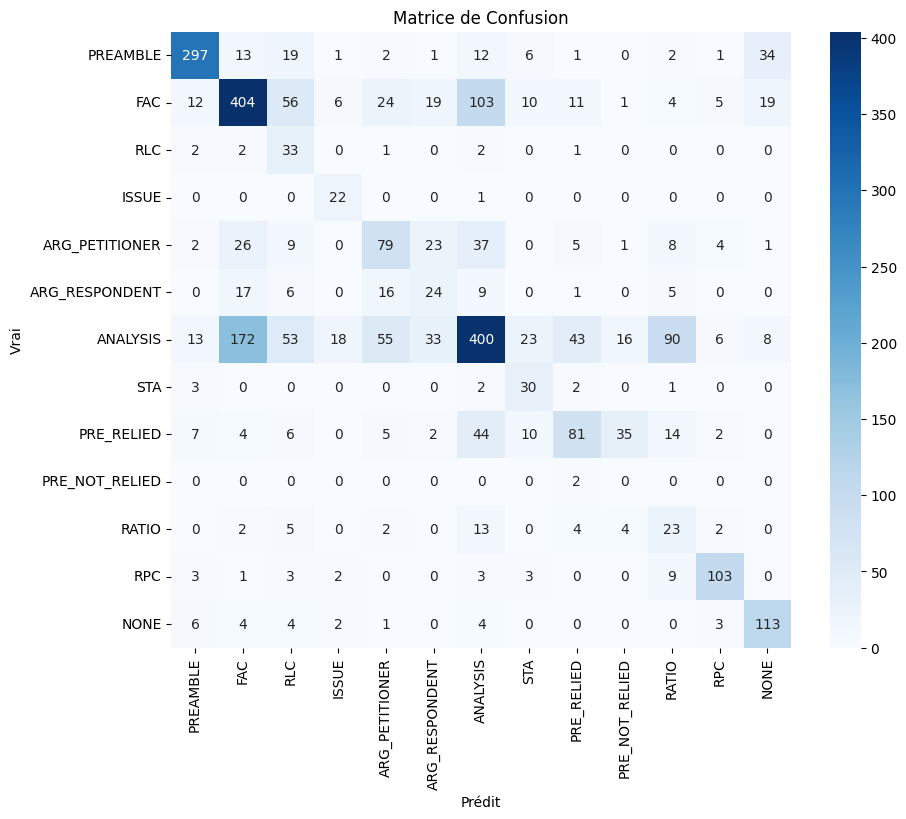

In [ ]:
# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=rr_labels, yticklabels=rr_labels)
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de Confusion')
plt.show()

In [ ]:
#afficher dans un dataframe pandas la matrice de confusion
df_confusion = pd.DataFrame(confusion, index=rr_labels, columns=rr_labels)

### Analyse d'erreur

In [ ]:
# Faire des prédictions sur les données de validation
predictions = trainer.predict(valid_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Obtenir les vraies étiquettes
true_labels = [valid_dataset[i]['labels'] for i in range(len(valid_dataset))]

# Trouver les indices des erreurs de classification
mismatched_indices = np.where(preds != true_labels)[0]

# Récupérer les exemples mal classifiés
misclassified_examples = [valid_dataset[i] for i in mismatched_indices]

# Fonction pour décodifier les tokens en texte
def decode_tokens(token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True)

# Afficher les exemples mal classifiés avec leurs prédictions et les vrais labels
for i in mismatched_indices[:5]:  # Limitez le nombre d'exemples à afficher
    text = decode_tokens(valid_dataset[i]['input_ids'])
    print(f"Text: {text}")
    print(f"Predicted label: {rr_labels[preds[i]]}")
    print(f"True label: {rr_labels[true_labels[i]]}")
    print("\n")


Text: the appellate tribunal has referred to this decision in its impugned order.
Predicted label: RLC
True label: RATIO


Text: similarly, in view of the orders of the assistant commissioner, division c, bangalore, which has remained unchallenged as regards the quantum of refund of unutilized cenvat credit, there cannot be any lis even as regards the quantum.
Predicted label: ANALYSIS
True label: RATIO


Text: % 03. 05. 2017
Predicted label: PREAMBLE
True label: NONE


Text: questions of law 2.
Predicted label: NONE
True label: ISSUE


Text: its activities are administered by the board of directors ( bod ) comprising of seven officers of the directorate of education in an ex - officio capacity and two members nominated by the lieutenant governor of delhi.
Predicted label: ANALYSIS
True label: FAC




### Extraction erreur LegalBert et DistilBert

In [ ]:
# Charger le modèle LegalBert sauvegardé
LegalBert_best_model = load_model( os.path.join(ROOT, 'Model/LegalBert'), device)
# Charger le tokenizer LegalBert sauvegardé
LegalBert_best_tokenizer = load_tokenizer( os.path.join(ROOT, 'Model/LegalBert_Tokenizer'))

# Charger le modèle DistilBert sauvegardé
DistilBert_best_model = load_model( os.path.join(ROOT, 'Model/DistilBert'), device)
# Charger le tokenizer DistilBertsauvegardé
DistilBert_best_tokenizer = load_tokenizer( os.path.join(ROOT, 'Model/DistilBert_Tokenizer'))

# Charger le modèle RoBERTa sauvegardé
roberta_best_model = load_model(os.path.join(ROOT, 'Model/Roberta'), device)
# Charger le tokenizer RoBERTa sauvegardé
roberta_best_tokenizer = load_tokenizer(os.path.join(ROOT, 'Model/Roberta_Tokenizer'))


In [ ]:
# Utiliser la classe BUILDDataset pour préparer les données de validation.
valid_dataset_LegalBert = BUILDDataset(valid_df, LegalBert_best_tokenizer, device, include_labels=True)


In [ ]:
# Utiliser la classe BUILDDataset pour préparer les données de validation.
valid_dataset_distilbert = BUILDDataset(valid_df, DistilBert_best_tokenizer, device, include_labels=True)


In [ ]:
# Utiliser la classe BUILDDataset pour préparer les données de validation pour RoBERTa
valid_dataset_roberta = BUILDDataset(valid_df, roberta_best_tokenizer, device, include_labels=True)

In [ ]:
# Créer une instance de DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=LegalBert_best_tokenizer, return_tensors="pt")

In [ ]:
# Créer une instance de Trainer pour le modèle LegalBert
legalbert_trainer = Trainer(model=LegalBert_best_model,data_collator=data_collator)

# Faire des prédictions sur le dataset de validation
legalbert_predictions = legalbert_trainer.predict(valid_dataset_LegalBert)
legalbert_preds = np.argmax(legalbert_predictions.predictions, axis=1)

# Identifier où les prédictions diffèrent des vraies étiquettes
legalbert_mismatches = np.where(legalbert_preds != valid_dataset_LegalBert.labels)[0]


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
# Créer une instance de Trainer pour le modèle DistilBERT
distilbert_trainer = Trainer(model=DistilBert_best_model,data_collator=data_collator)

# Faire des prédictions sur le dataset de validation préparé pour DistilBERT
distilbert_predictions = distilbert_trainer.predict(valid_dataset_distilbert )
distilbert_preds = np.argmax(distilbert_predictions.predictions, axis=1)

# Identifier où les prédictions diffèrent des vraies étiquettes
distilbert_mismatches = np.where(distilbert_preds != valid_dataset_distilbert .labels)[0]


In [ ]:
# Créer une instance de Trainer pour le modèle RoBERTa
roberta_trainer = Trainer(model=roberta_best_model, data_collator=data_collator)

# Faire des prédictions sur le dataset de validation préparé pour RoBERTa
roberta_predictions = roberta_trainer.predict(valid_dataset_roberta)
roberta_preds = np.argmax(roberta_predictions.predictions, axis=1)

#### Heatmap prediction des modèles sur le dataset de validation

In [ ]:
# Extraire les étiquettes réelles du dataset de validation
true_labels = np.array(valid_dataset_LegalBert.labels)

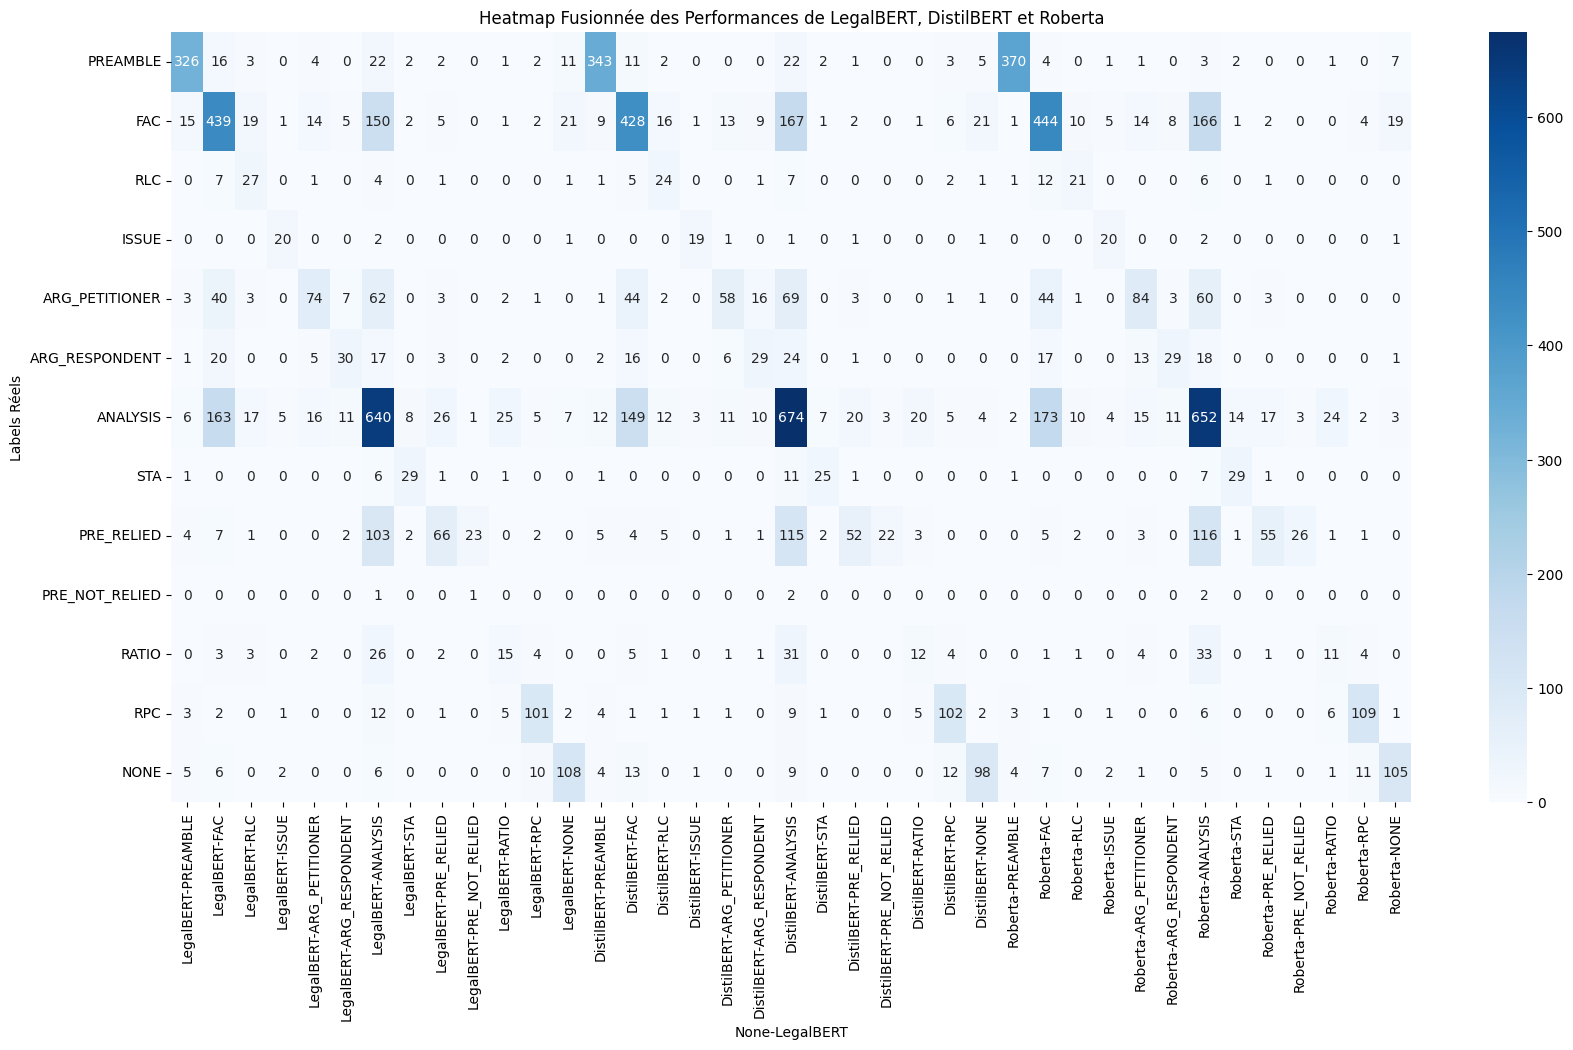

In [ ]:
# Créer un mapping de labels numériques à textuels
mapping_labels = {num: label for num, label in enumerate(rr_labels)}

# Remplacer les labels numériques par des labels textuels dans les matrices de confusion
confusion_matrix_legalbert = pd.crosstab(true_labels, legalbert_preds, rownames=['Labels Réels'], colnames=['LegalBERT']).rename(index=mapping_labels, columns=mapping_labels)
confusion_matrix_distilbert = pd.crosstab(true_labels, distilbert_preds, rownames=['Labels Réels'], colnames=['DistilBERT']).rename(index=mapping_labels, columns=mapping_labels)
confusion_matrix_roberta = pd.crosstab(true_labels, roberta_preds, rownames=['Labels Réels'], colnames=['Roberta']).rename(index=mapping_labels, columns=mapping_labels)

# Fusionner les deux matrices de confusion
combined_confusion_matrix = pd.concat([confusion_matrix_legalbert, confusion_matrix_distilbert, confusion_matrix_roberta],keys=['LegalBERT', 'DistilBERT', 'Roberta'], axis=1)

# Afficher la heatmap avec les labels textuels
plt.figure(figsize=(20, 10))
sns.heatmap(combined_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap Fusionnée des Performances de LegalBERT, DistilBERT et Roberta')
plt.show()


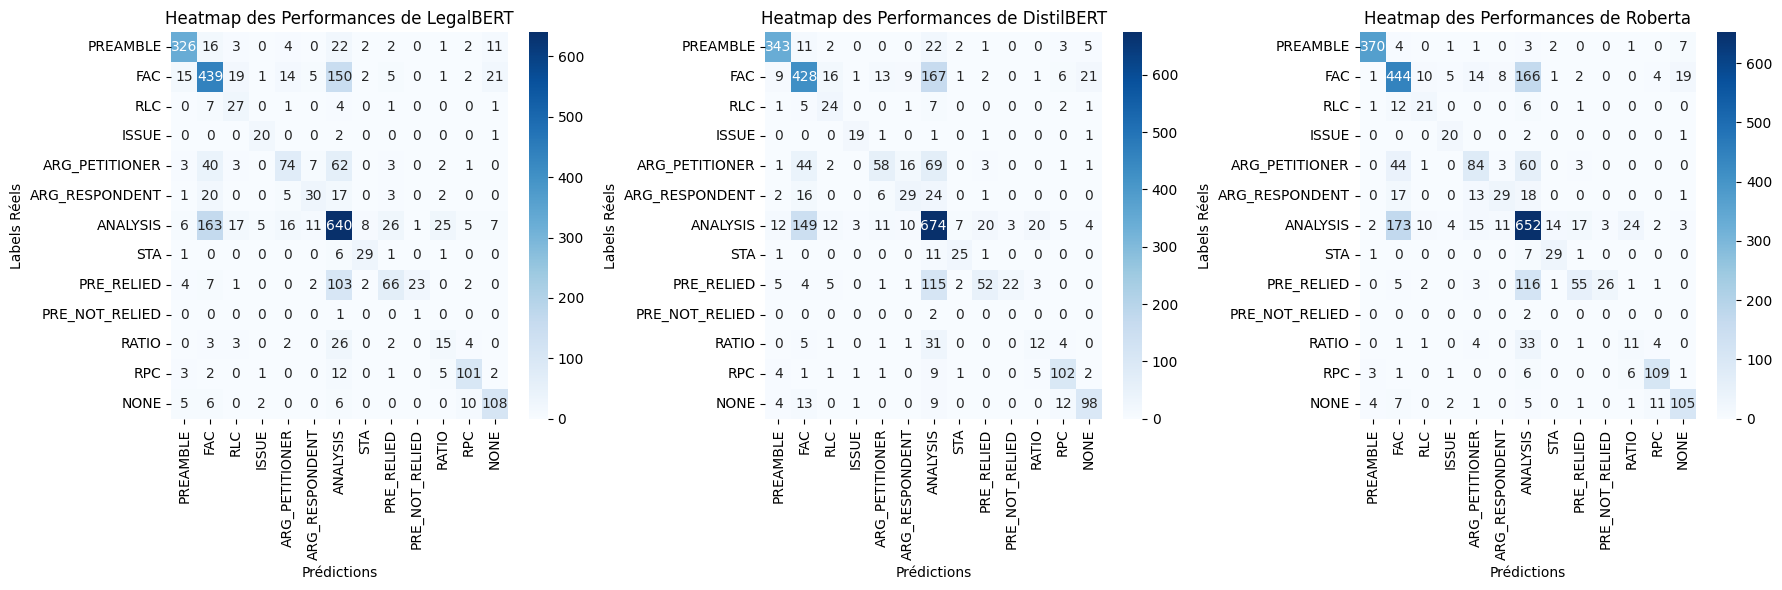

In [ ]:
# Créer un mapping de labels numériques à textuels
mapping_labels = {num: label for num, label in enumerate(rr_labels)}

# Remplacer les labels numériques par des labels textuels dans les matrices de confusion
confusion_matrix_legalbert = pd.crosstab(true_labels, legalbert_preds, rownames=['Labels Réels'], colnames=['Prédictions']).rename(index=mapping_labels, columns=mapping_labels)
confusion_matrix_distilbert = pd.crosstab(true_labels, distilbert_preds, rownames=['Labels Réels'], colnames=['Prédictions']).rename(index=mapping_labels, columns=mapping_labels)
confusion_matrix_roberta = pd.crosstab(true_labels, roberta_preds, rownames=['Labels Réels'], colnames=['Prédictions']).rename(index=mapping_labels, columns=mapping_labels)

# Afficher les heatmaps séparément
plt.figure(figsize=(18, 6))

# Heatmap pour LegalBERT
plt.subplot(1, 3, 1)  # 1 ligne, 3 colonnes, 1er graphique
sns.heatmap(confusion_matrix_legalbert, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap des Performances de LegalBERT')

# Heatmap pour DistilBERT
plt.subplot(1, 3, 2)  # 1 ligne, 3 colonnes, 2e graphique
sns.heatmap(confusion_matrix_distilbert, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap des Performances de DistilBERT')

# Heatmap pour Roberta
plt.subplot(1, 3, 3)  # 1 ligne, 3 colonnes, 3e graphique
sns.heatmap(confusion_matrix_roberta, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap des Performances de Roberta')

# Afficher les graphiques
plt.tight_layout()
plt.show()


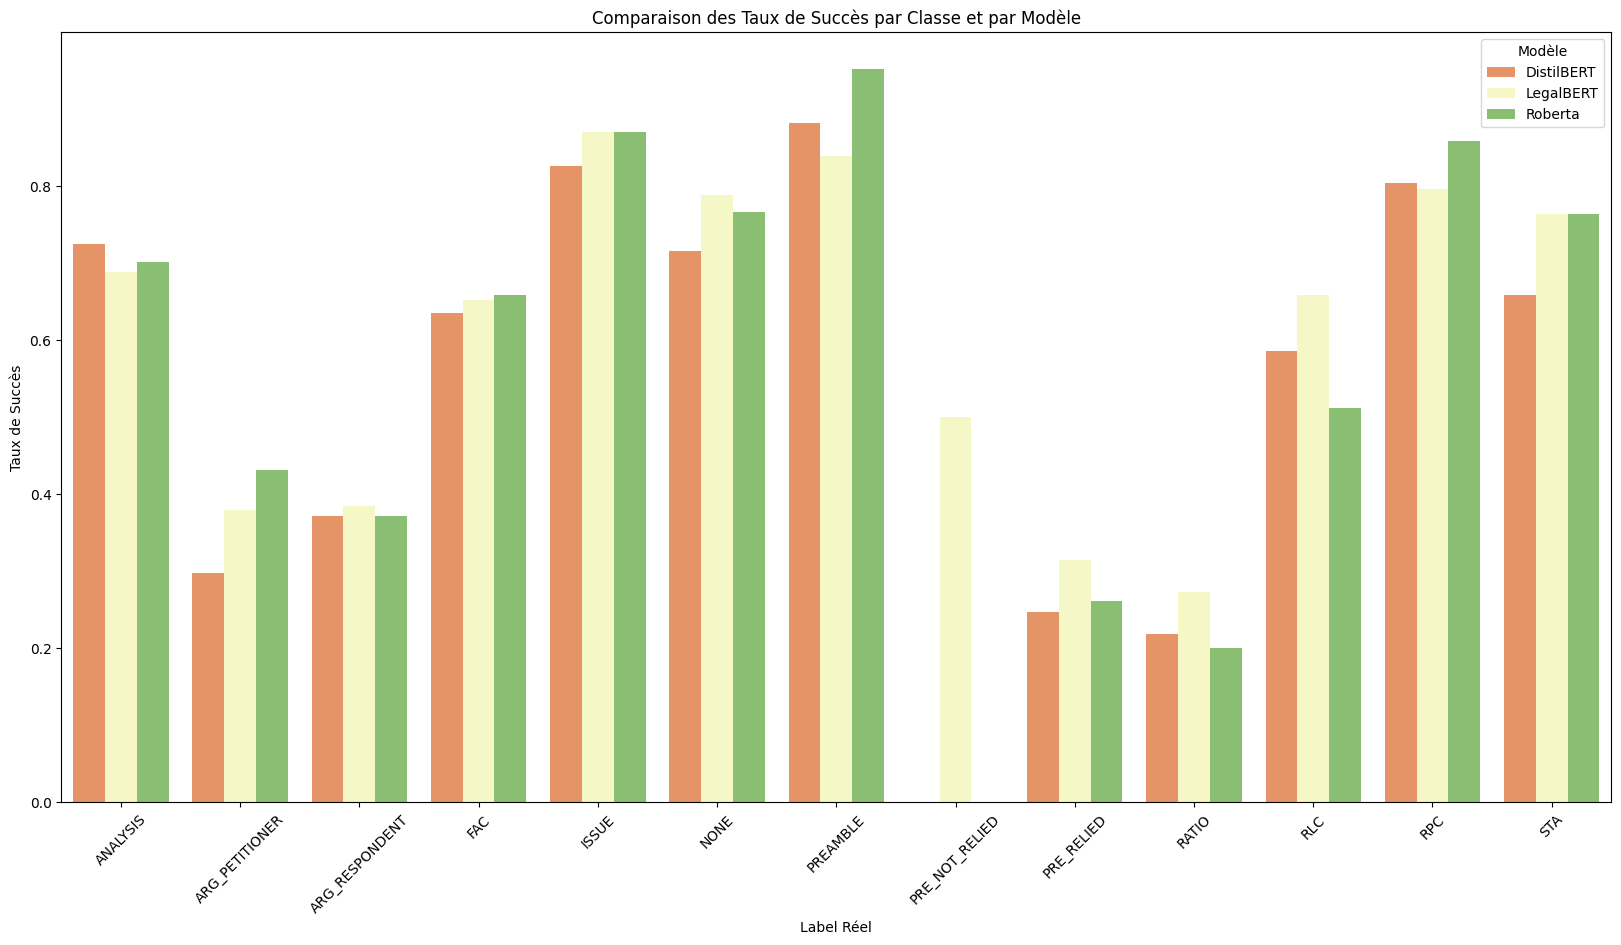

In [ ]:
# Convertir les labels numériques en labels textuels
labels_textuels = [rr_labels[label] for label in true_labels]

# Créer un DataFrame pour les prédictions de chaque modèle
df_legalbert = pd.DataFrame({'Label Réel': labels_textuels, 'Prédiction': [rr_labels[pred] for pred in legalbert_preds], 'Modèle': 'LegalBERT'})
df_distilbert = pd.DataFrame({'Label Réel': labels_textuels, 'Prédiction': [rr_labels[pred] for pred in distilbert_preds], 'Modèle': 'DistilBERT'})
df_roberta = pd.DataFrame({'Label Réel': labels_textuels, 'Prédiction': [rr_labels[pred] for pred in roberta_preds], 'Modèle': 'Roberta'})

# Fusionner les deux DataFrames
df_predictions = pd.concat([df_legalbert, df_distilbert, df_roberta])

# Calculer les taux de succès pour chaque modèle et chaque classe
taux_succes = df_predictions.groupby(['Label Réel', 'Modèle']).apply(lambda x: (x['Label Réel'] == x['Prédiction']).mean()).reset_index(name='Taux de Succès')

# Afficher le diagramme en barres
plt.figure(figsize=(20, 10))
sns.barplot(data=taux_succes, x='Label Réel', y='Taux de Succès', hue='Modèle', palette='RdYlGn')
plt.xticks(rotation=45)
plt.title('Comparaison des Taux de Succès par Classe et par Modèle')
plt.show()


In [ ]:
"""df_legalbert.to_csv(os.path.join(ROOT, 'legalBert_prediction.csv'), index=False)
df_distilbert.to_csv(os.path.join(ROOT, 'distilbert_prediction.csv'), index=False)
df_roberta.to_csv(os.path.join(ROOT, 'roberta_prediction.csv'), index=False)"""

"df_legalbert.to_csv(os.path.join(ROOT, 'legalBert_prediction.csv'), index=False)\ndf_distilbert.to_csv(os.path.join(ROOT, 'distilbert_prediction.csv'), index=False)\ndf_roberta.to_csv(os.path.join(ROOT, 'roberta_prediction.csv'), index=False)"

#### Récupération des erreurs commises par les modèles

In [ ]:
# Trouvez les erreurs communes entre les deux modèles
common_mismatches = np.intersect1d(legalbert_mismatches, distilbert_mismatches)

# Affichez quelques exemples d'erreurs communes
for idx in common_mismatches[:10]:  # Affichez les 10 premiers exemples
    text = valid_df.iloc[idx]['text']  # Utilisez le DataFrame de validation original pour obtenir le texte
    real_label = rr_labels[valid_df.iloc[idx]['labels_class']]
    print(f"Phrase: {text}")
    print(f"Label réel: {real_label}")
    print(f"Prédiction LegalBERT: {rr_labels[legalbert_preds[idx]]}")
    print(f"Prédiction DistilBERT: {rr_labels[distilbert_preds[idx]]}\n")


Phrase: The Appellate Tribunal has referred to this decision in its impugned order.
Label réel: RATIO
Prédiction LegalBERT: RLC
Prédiction DistilBERT: FAC

Phrase: 
 Similarly, in view of the orders of the Assistant Commissioner, Division  C, Bangalore, which has remained unchallenged as regards the quantum of refund of unutilized CENVAT credit, there cannot be any lis even as regards the quantum.
Label réel: RATIO
Prédiction LegalBERT: ANALYSIS
Prédiction DistilBERT: ANALYSIS

Phrase: 
 Questions of law 2.
Label réel: ISSUE
Prédiction LegalBERT: NONE
Prédiction DistilBERT: NONE

Phrase: The books are provided at subsidized rates by the Assessee.
Label réel: FAC
Prédiction LegalBERT: ANALYSIS
Prédiction DistilBERT: ARG_RESPONDENT

Phrase: There is nominal profit to school students and wholesale dealers.
Label réel: FAC
Prédiction LegalBERT: ANALYSIS
Prédiction DistilBERT: ANALYSIS

Phrase: Past tax history 8.
Label réel: FAC
Prédiction LegalBERT: ANALYSIS
Prédiction DistilBERT: ANALYSI

In [ ]:
# Créer une liste pour stocker les erreurs
errors_data = []

# Collecter les données d'erreur
for idx in common_mismatches:
    text = valid_df.iloc[idx]['text']  # Le texte de l'exemple
    real_label = rr_labels[valid_df.iloc[idx]['labels_class']]  # L'étiquette réelle
    legalbert_pred = rr_labels[legalbert_preds[idx]]  # La prédiction de LegalBERT
    distilbert_pred = rr_labels[distilbert_preds[idx]]  # La prédiction de DistilBERT

    # Ajouter au tableau d'erreurs
    errors_data.append({
        'text': text,
        'Label réel': real_label,
        'Prédiction LegalBERT': legalbert_pred,
        'Prédiction DistilBERT': distilbert_pred
    })

# Convertir la liste en DataFrame
errors_df = pd.DataFrame(errors_data)

# Enregistrer le DataFrame dans un fichier CSV
errors_csv_path = os.path.join(ROOT, 'errors_comparison.csv')
errors_df.to_csv(errors_csv_path, index=False)


## Analyse d'erreur

In [ ]:
# lire le fichier sauvegardé
errors_df_path = os.path.join(ROOT, 'errors_comparison.csv')
errors_df = pd.read_csv(errors_df_path)

In [ ]:
# Calculer les erreurs communes
errors_df['Même Erreur'] = errors_df['Prédiction LegalBERT'] == errors_df['Prédiction DistilBERT']
common_errors_count = errors_df['Même Erreur'].sum()
total_errors = len(errors_df)
print(f"Nombre d'erreurs communes: {common_errors_count}")
print(f"Nombre total d'erreurs: {total_errors}")
print(f"Proportion d'erreurs communes: {common_errors_count / total_errors:.2f}")

Nombre d'erreurs communes: 607
Nombre total d'erreurs: 782
Proportion d'erreurs communes: 0.78


In [ ]:
# Exemple d'analyse des termes juridiques spécifiques
from collections import Counter
import nltk

nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Tokenisation et comptage des mots
words = word_tokenize(' '.join(errors_df['text'].values))
words = [word for word in words if word.isalpha() and word not in stopwords.words('english')]
word_freq = Counter(words)

# Afficher les mots les plus communs dans les erreurs
print("Mots communs dans les erreurs de classification :")
print(word_freq.most_common(15))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mots communs dans les erreurs de classification :
[('The', 162), ('Court', 114), ('accused', 82), ('It', 64), ('power', 61), ('also', 59), ('case', 58), ('Section', 57), ('evidence', 56), ('Act', 54), ('tax', 48), ('said', 48), ('List', 37), ('deceased', 36), ('stated', 36)]


In [ ]:
# Calculer le nombre de mots par texte dans errors_df
errors_df['mots_par_texte'] = errors_df['text'].apply(lambda x: len(x.split()))

# Afficher les premières lignes pour vérifier
print(errors_df[['text', 'mots_par_texte']].head())


                                                text  mots_par_texte
0  The Appellate Tribunal has referred to this de...              12
1  \n Similarly, in view of the orders of the Ass...              37
2                             \n Questions of law 2.               4
3  The books are provided at subsidized rates by ...              10
4  There is nominal profit to school students and...              10


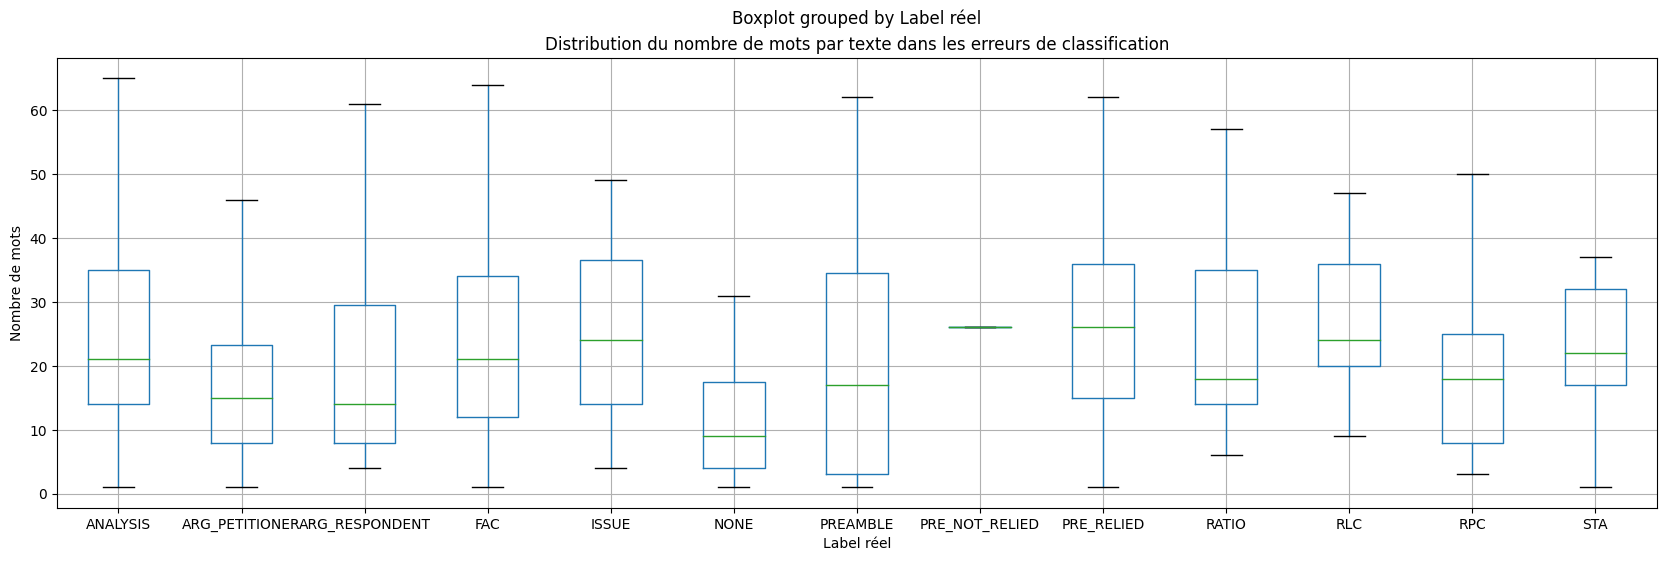

In [ ]:
# Créer un boxplot pour la distribution des longueurs de texte
errors_df.boxplot(column='mots_par_texte', by='Label réel', figsize=(20, 6), showfliers=False)
plt.title('Distribution du nombre de mots par texte dans les erreurs de classification')
plt.ylabel('Nombre de mots')
plt.show()


In [ ]:
# Fonction pour compter les erreurs
def count_errors(predictions, actual):
    return (predictions != actual).sum()

# Appliquer la fonction pour chaque classe et chaque modèle
error_counts = errors_df.groupby('Label réel').apply(lambda df: pd.Series({
    'Erreurs_LegalBERT': count_errors(df['Prédiction LegalBERT'], df['Label réel']),
    'Erreurs_DistilBERT': count_errors(df['Prédiction DistilBERT'], df['Label réel'])
})).reset_index()

# Afficher le résultat
print(error_counts)


        Label réel  Erreurs_LegalBERT  Erreurs_DistilBERT
0         ANALYSIS                173                 173
1   ARG_PETITIONER                112                 112
2   ARG_RESPONDENT                 43                  43
3              FAC                172                 172
4            ISSUE                  3                   3
5             NONE                 24                  24
6         PREAMBLE                 43                  43
7   PRE_NOT_RELIED                  1                   1
8       PRE_RELIED                135                 135
9            RATIO                 37                  37
10             RLC                 13                  13
11             RPC                 17                  17
12             STA                  9                   9


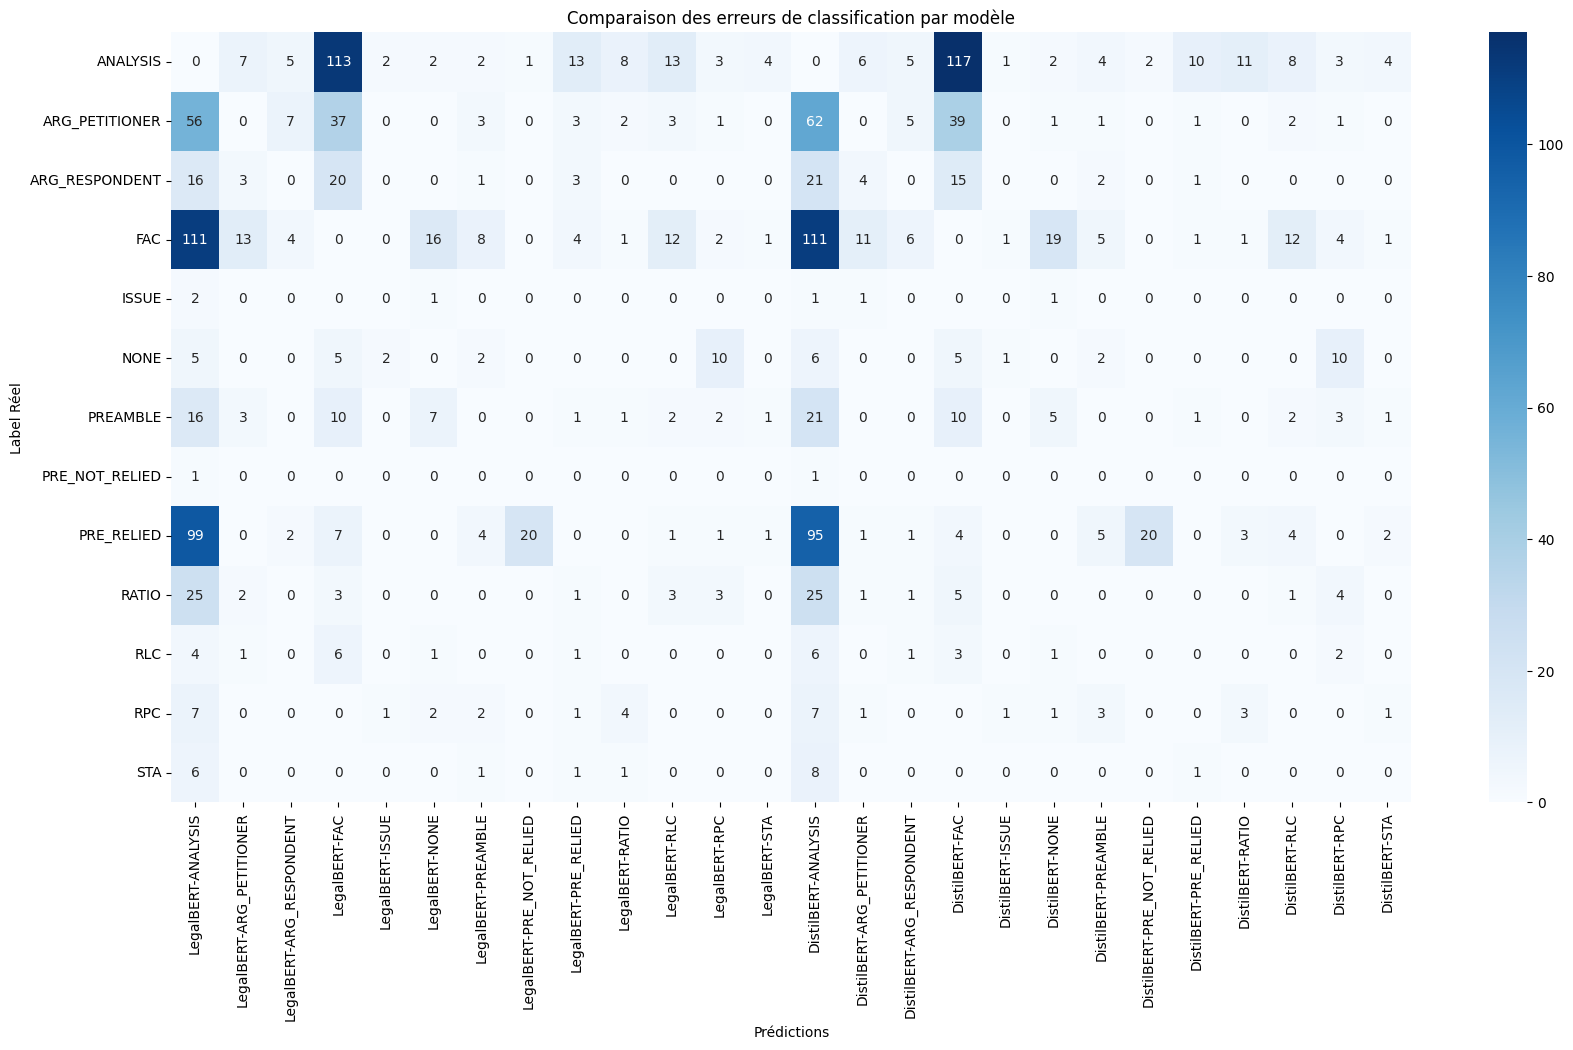

In [ ]:
# Créer une matrice de confusion combinée
confusion_matrix_combined = pd.DataFrame({
    'Label Réel': errors_df['Label réel'],
    'LegalBERT': errors_df['Prédiction LegalBERT'],
    'DistilBERT': errors_df['Prédiction DistilBERT']
})

# Calculer la matrice de confusion pour chaque modèle
confusion_legalbert = pd.crosstab(confusion_matrix_combined['Label Réel'], confusion_matrix_combined['LegalBERT'])
confusion_distilbert = pd.crosstab(confusion_matrix_combined['Label Réel'], confusion_matrix_combined['DistilBERT'])

# Combiner les matrices côte à côte
combined_matrix = pd.concat([confusion_legalbert, confusion_distilbert], axis=1, keys=['LegalBERT', 'DistilBERT'])

# Afficher la heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(combined_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Comparaison des erreurs de classification par modèle')
plt.ylabel('Label Réel')
plt.xlabel('Prédictions')
plt.show()


#### Analyse des Termes Juridiques dans le Dataset Augmenté



In [ ]:
# Tokenisation et comptage des mots (cellule assez longue ~9min d'exec)
extended_words = word_tokenize(' '.join(extended_train_df['text'].values))
extended_words = [word.lower() for word in extended_words if word.isalpha() and word.lower() not in stopwords.words('english')]
extended_word_freq = Counter(extended_words)

# Afficher les mots les plus communs dans le dataset augmenté
print("Mots communs dans le dataset augmenté :")
print(extended_word_freq.most_common(15))


Mots communs dans le dataset augmenté :
[('court', 35962), ('case', 25305), ('order', 21399), ('section', 20435), ('act', 19822), ('petitioner', 19584), ('learned', 14038), ('respondent', 13779), ('also', 13164), ('made', 11256), ('said', 11082), ('would', 10554), ('appeal', 10007), ('dated', 9722), ('state', 9709)]


In [ ]:
# Catégories d'intérêt
categories_of_interest = ['FAC', 'ARG_PETITIONER', 'ANALYSIS', 'PRE_RELIED']

# Créer un Counter pour chaque catégorie
category_word_freq = {category: Counter() for category in categories_of_interest}

# Filtrer les erreurs et compter les mots pour chaque catégorie
for category in categories_of_interest:
    # Filtrer les erreurs pour la catégorie actuelle
    category_errors = errors_df[errors_df['Label réel'] == category]

    # Tokeniser et compter les mots
    for text in category_errors['text']:
        words = word_tokenize(text.lower())
        words = [word for word in words if word.isalpha() and word not in stopwords.words('english')]
        category_word_freq[category].update(words)

# Afficher les mots les plus communs dans les erreurs pour chaque catégorie
for category in categories_of_interest:
    print(f"Mots communs dans les erreurs de classification pour la catégorie {category}:")
    print(category_word_freq[category].most_common(15))
    print("\n")


Mots communs dans les erreurs de classification pour la catégorie FAC:
[('court', 31), ('section', 23), ('college', 18), ('said', 15), ('evidence', 15), ('îzgg', 14), ('case', 13), ('also', 13), ('accused', 13), ('order', 12), ('act', 12), ('medical', 12), ('patients', 12), ('petitioner', 12), ('assessee', 11)]


Mots communs dans les erreurs de classification pour la catégorie ARG_PETITIONER:
[('court', 18), ('evidence', 15), ('accused', 13), ('petitioner', 12), ('said', 12), ('alleged', 11), ('stated', 11), ('persons', 11), ('petitioners', 11), ('also', 10), ('village', 10), ('incident', 10), ('statement', 9), ('case', 9), ('offences', 7)]


Mots communs dans les erreurs de classification pour la catégorie ANALYSIS:
[('accused', 39), ('act', 24), ('also', 21), ('court', 19), ('deceased', 16), ('house', 16), ('section', 15), ('tax', 15), ('police', 15), ('said', 13), ('hospital', 12), ('appellant', 11), ('stated', 11), ('assessee', 10), ('college', 10)]


Mots communs dans les erreurs

In [ ]:
# Étape 1: Identifier les indices des erreurs pour chaque catégorie
def get_misclassified_indices(predictions, true_labels, label_name_to_id):
    misclassified = {}
    for label_name, label_id in label_name_to_id.items():
        misclassified_indices = np.where((predictions == label_id) & (true_labels != label_id))[0]
        misclassified[label_name] = misclassified_indices
    return misclassified

# Créez un dictionnaire pour mapper les noms de labels à leurs IDs
label_name_to_id = {label: i for i, label in enumerate(rr_labels)}

# Obtenez les indices mal classifiés pour LegalBERT, DistilBERT et RoBERTa
misclassified_legalbert = get_misclassified_indices(legalbert_preds, true_labels, label_name_to_id)
misclassified_distilbert = get_misclassified_indices(distilbert_preds, true_labels, label_name_to_id)
misclassified_roberta = get_misclassified_indices(roberta_preds, true_labels, label_name_to_id)

# Étape 2: Extraire les textes des indices mal classifiés pour chaque catégorie
def extract_texts(df, misclassified_indices):
    texts = df.iloc[misclassified_indices]['text'].values
    return texts

# Sélectionnez les catégories d'intérêt
categories_of_interest = ['FAC', 'ARG_PETITIONER', 'ANALYSIS', 'PRE_RELIED']

# Extraire les textes pour chaque modèle et catégorie
misclassified_texts = {}
for category in categories_of_interest:
    misclassified_texts[category] = {
        'LegalBERT': extract_texts(valid_df, misclassified_legalbert[category]),
        'DistilBERT': extract_texts(valid_df, misclassified_distilbert[category]),
        'RoBERTa': extract_texts(valid_df, misclassified_roberta[category])
    }

In [ ]:
# Étape 3: Analyser les similarités entre les textes mal classifiés
# Vous pouvez utiliser des techniques telles que l'analyse de texte, la tokenisation,
# le comptage de mots, etc., pour identifier des patterns ou des similarités.

# Par exemple, pour afficher quelques phrases mal classifiées dans chaque catégorie pour LegalBERT:
for category in categories_of_interest:
    print(f"Categorie: {category}")
    print("Phrases mal classifiées par LegalBERT:")
    for text in misclassified_texts[category]['LegalBERT'][:5]:  # Affichez les 5 premières phrases
        print(f"- {text}")
    print("\n")

Categorie: FAC
Phrases mal classifiées par LegalBERT:
- 
 (c) The ITAT held that its earlier order dated 30th September 1980 for AYs 1975-76 and 1976-77 had not considered the income and expenditure statements filed by the Assessee for those AYs and other relevant evidence.
- It was observed that the facts on hand were different.
- The Board was then converted into a corporation in 1972.
- The entire share capital of the corporation was owned by the Government of Assam.
- There again, the AO sought to deny exemption on the ground that the Corporation was not an „educational institution‟ under Section 10 (22) of the Act.


Categorie: ARG_PETITIONER
Phrases mal classifiées par LegalBERT:
- ” Reliance was placed on the decision of the Supreme Court in Nachimuthu Industrial Association v. CIT (1999) 235 ITR 190 (SC).
- Countering the above submissions, Mr. Rahul Kaushik, learned Senior standing counsel for the Revenue, sought to support the impugned order of the ITAT by pointing out that t

## Conclusion première analyse

Nous souhaitions d'abord répondre à ces questions :

- Tous les systèmes font-il les mêmes erreurs ?

--> il semble que oui au vu des heatmap sur les predictions de LB,DB et RB; deplus les erreurs sont quasiment les même (même mauvaise catégorie prédite par les 3 modèles)
--> PB de données, du surement au déséquilibre du train_dataset beaucoup de catégorie sont prédite comme des Analysis et c'est la classe la plus sur-représentée
--> Equilibrer le dataset d'entrainement baisse légèrement les performances (prec,rappel,f1), réduction des erreurs sur qlq catégories, augmentation des erreurs sur les classe sur-représenté à l'origine, Soit le dataset est encore trop déséquilibré soit le self-learning à causé l'apprentissage d'erreurs.

- Y a t-il des phrases plus dures que d'autres ?

- Quels rôles rhétoriques sont les mieux/moins bien classifiés ?

--> Les classes ayant le plus d'exemples dans le train_set (Analysis, FAC, Preamble)  sont les mieux prédites en général

- Y-a-t-il des similarités entre les phrases mal classifiées ? si oui, lesquelles ?

--> Oui les phrases mal classifiées en général comporte des mots du domaine juridique :

__Mots communs dans les erreurs de classification :__
[('Court', 114), ('accused', 82), ('case', 58),('evidence', 56), ('Act', 54), ('tax', 48), ('deceased', 36), ('stated', 36)]

Ces même mots technique juridique apparaissent aussi largement dans le train_set :
__Mots communs dans le dataset augmenté :__
[('court', 35962), ('case', 25305), ('order', 21399), ('section', 20435), ('act', 19822), ('petitioner', 19584), ('learned', 14038), ('respondent', 13779),('appeal', 10007)]

__Mots communs dans les erreurs de classification pour la catégorie FAC:__
[('court', 31), ('section', 23), ('college', 18), ('said', 15), ('evidence', 15), ('îzgg', 14), ('case', 13), ('also', 13), ('accused', 13), ('order', 12), ('act', 12), ('medical', 12), ('patients', 12), ('petitioner', 12), ('assessee', 11)]


__Mots communs dans les erreurs de classification pour la catégorie ARG_PETITIONER:__
[('court', 18), ('evidence', 15), ('accused', 13), ('petitioner', 12), ('said', 12), ('alleged', 11), ('stated', 11), ('persons', 11), ('petitioners', 11), ('also', 10), ('village', 10), ('incident', 10), ('statement', 9), ('case', 9), ('offences', 7)]


__Mots communs dans les erreurs de classification pour la catégorie ANALYSIS:__
[('accused', 39), ('act', 24), ('also', 21), ('court', 19), ('deceased', 16), ('house', 16), ('section', 15), ('tax', 15), ('police', 15), ('said', 13), ('hospital', 12), ('appellant', 11), ('stated', 11), ('assessee', 10), ('college', 10)]


__Mots communs dans les erreurs de classification pour la catégorie PRE_RELIED:__
[('power', 51), ('list', 35), ('tax', 27), ('entry', 23), ('court', 16), ('ii', 15), ('parliament', 14), ('law', 13), ('entries', 13), ('would', 12), ('state', 11), ('held', 11), ('evidence', 11), ('india', 11), ('subject', 11)]



# Amélioration de la méthode transformer

Utilisation de données externes (self-learning)
1. Récolter des documents similaires non annotés --> utilisation d'un dataset tiré de indianKanoon dispo sur Kaggle (mise en forme avec la baseline proposée par legalEval)
2. Appliquer la prédiction d’un modèle --> utilsation du transformer pour la prediction
3. Choisir les prédictions les plus sûres
4. Ajouter les documents et leur annotation au corpus d’entraînement
5. Affiner le modèle

#### Charger le modèle et le tokenizer sauvegardés :

In [ ]:
# Charger le modèle sauvegardé (cahnger le chemin au besoin)
best_model = load_model( os.path.join(ROOT, 'Model/Model'), device)
# Charger le tokenizer sauvegardé
best_tokenizer = load_tokenizer( os.path.join(ROOT, 'Model/Tokenizer'))


#### Préparer le dataset pour la prédiction :

In [ ]:
# Charger les données JSON
with open(os.path.join(ROOT, 'BUILD/case_processed_5000.json'), 'r') as file:
    new_data_json = json.load(file)

# Convertir en DataFrame
new_data_df = pd.DataFrame(new_data_json)
#new_data_df.rename(columns={'text': 'data'}, inplace=True)

# Créer un dataset pour la prédiction
predict_dataset = BUILDDataset(new_data_df, best_tokenizer, device, include_labels=False)

In [ ]:
#new_data_df.head(2)

#### Faire des prédictions :

In [ ]:
# Créer une instance de DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=best_tokenizer, return_tensors="pt")

# Préparer l'objet Trainer pour la prédiction avec le DataCollator
predictor = Trainer(
    model=best_model.to(device),
    data_collator=data_collator)

In [ ]:
# Faire des prédictions
new_predictions = predictor.predict(predict_dataset)
new_preds = np.argmax(new_predictions.predictions, axis=1)

#### Sélectionner les prédictions les plus sûres et les ajouter au corpus d'entraînement :

In [ ]:
seuil_confiance = 0.9  # Ajuster ce seuil au besoin
high_confidence_indices = np.where(new_predictions.predictions.max(axis=1) > seuil_confiance)[0]
high_confidence_data = new_data_df.iloc[high_confidence_indices]
high_confidence_labels = [rr_labels[pred] for pred in new_preds[high_confidence_indices]]
high_confidence_data['labels'] = high_confidence_labels

# Concaténer avec l'ensemble d'entraînement existant
extended_train_df = pd.concat([train_df, high_confidence_data])
extended_train_df['labels_class'] = extended_train_df['labels'].apply(lambda x: MAP_LABEL.get(x, x))
extended_train_dataset = BUILDDataset(extended_train_df, best_tokenizer, device)